In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [107]:
file_data = pd.read_csv("football_data.csv",encoding='latin1')
file_data.shape

(18207, 89)

# Cleaning the data


In [108]:
# removing rows with wrong placement of data and empty entries
indexes = []
for index,rows in file_data.iterrows():
  if rows['Club Logo'][:5] !='https' or rows['LS'] != rows['LS']:
    indexes.append(index)
print(len(indexes))
file_data = file_data.drop(file_data.index[indexes])
file_data.reset_index(drop=True, inplace=True)
file_data_copy = file_data
file_data.shape

2085


(16122, 89)

In [109]:
#select columns which are useful numerical values
positions = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']
useful = ['Age','Overall','Potential','Value','Wage','Special','International Reputation','Skill Moves',
          'Height','Weight','Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve',
          'FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions','Balance',
          'ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions','Positioning',
          'Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle','GKDiving','GKHandling',
          'GKKicking','GKPositioning','GKReflexes']
useful.extend(positions)
print(useful)
file_data = file_data[useful]

['Age', 'Overall', 'Potential', 'Value', 'Wage', 'Special', 'International Reputation', 'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']


In [110]:
import re
def modifyValue(val):
  if val != val:
    return 0
  if type(val) == str:
    val = re.sub('[^A-Z0-9\.]', '', val)
    # val = val[7:]
    last = val[-1]
    if last not in ['K','M']:
      return 0
    val = val[:-1]
    val = float(val)
    val *=1000
    if last == 'M':
      val *= 1000
    return val
  return val 

file_data['Value'] = file_data['Value'].apply(modifyValue)
# print(file_data['Value']) 
file_data['Wage'] = file_data['Wage'].apply(modifyValue)  
# print(file_data['Wage'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
def modifyHeight(val):
  # print(val)
  val = val.split('\'')
  val = float(val[0])*12 + float(val[1])
  return val

file_data['Height'] = file_data['Height'].apply(modifyHeight)
# print(file_data['Height'])  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [112]:
def modifyWeight(weight):
  if type(weight) == str:
    weight = weight.replace('lbs','')
    return float(weight)

file_data['Weight'] = file_data['Weight'].apply(modifyWeight)
# print(file_data['Weight'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [113]:
def position(val):
  # print(val)
  val = val.split('+')
  val = float(val[0]) + float(val[1])
  return val

for pos in positions:
  file_data[pos] = file_data[pos].apply(position)
# print(file_data['LS'])      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# K-means Clustering algorithm


In [114]:
from numpy.linalg import norm
class Kmeans:
  def __init__(self, K, max_iter=100,random_state=1):
    self.n_clusters = K
    self.max_iter = max_iter
    self.random_state = random_state

  def initialCentroids(self, X):
    np.random.RandomState(self.random_state)
    random_idx = np.random.permutation(X.shape[0])
    self.centroids = X[random_idx[:self.n_clusters]]

  def compute_distance(self, X, centroids):
    distance = np.zeros((X.shape[0], self.n_clusters))
    for k in range(self.n_clusters):
        row_norm = norm(X - centroids[k, :], axis=1)
        distance[:, k] = np.square(row_norm)
    return distance    

  def compute_centroids(self,X, labels):
    centroids = np.zeros((self.n_clusters, X.shape[1]))
    for k in range(self.n_clusters):
      centroids[k, :] = np.mean(X[labels == k, :], axis=0)
    return centroids

  def findKMeans(self, X):
    self.initialCentroids(X)
    for i in range(self.max_iter):
      old_centroids = self.centroids
      distance = self.compute_distance(X, old_centroids)
      self.labels = np.argmin(distance, axis=1)
      self.centroids = self.compute_centroids(X, self.labels)
      if np.all(old_centroids == self.centroids):
        break

# PCA


In [115]:
from sklearn.preprocessing import StandardScaler

X_std = file_data.values
X_std = StandardScaler().fit_transform(X_std)

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


Text(0.5, 1.0, 'Visualization of PCA data')

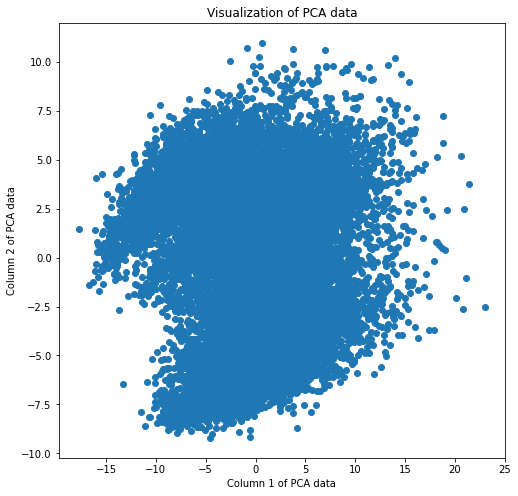

In [117]:
# plotting PCA
plt.figure(figsize=(8, 8))
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'])
plt.xlabel('Column 1 of PCA data')
plt.ylabel('Column 2 of PCA data')
plt.title('Visualization of PCA data')

# Plotting clustered data
Clusters = 3


[[ 0.8613634   0.57868764]
 [ 0.0193821  -1.13618555]
 [-0.98054513  0.67890944]]


Text(0.5, 1.0, 'Visualization of clustered data for k=3')

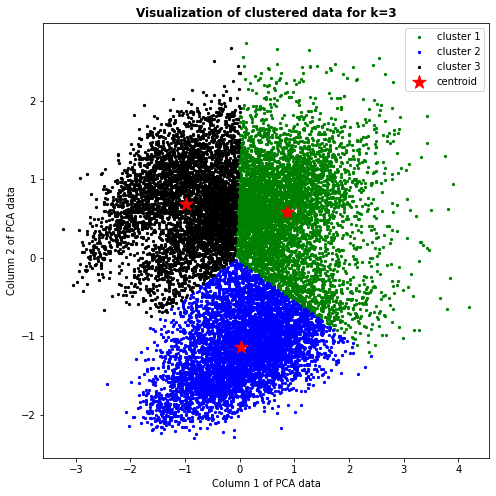

In [126]:
from sklearn.preprocessing import StandardScaler
# file_data['Value'] = file_data['Value'].apply(modifyValue)
# df = file_data[['Value','Finishing']]
# df['Weight'] = df['Weight'].apply(modifyWeight)  
# print(df)
X_std = StandardScaler().fit_transform(principalDf)
km = Kmeans(3,100)
km.findKMeans(X_std)
centroids = km.centroids
print(centroids)
siz=5
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1',s=siz)
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2',s=siz)
plt.scatter(X_std[km.labels == 2, 0], X_std[km.labels == 2, 1],
            c='black', label='cluster 3',s=siz)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200,
            c='r', label='centroid')
plt.legend( )
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.xlabel('Column 1 of PCA data')
plt.ylabel('Column 2 of PCA data')
plt.title('Visualization of clustered data for k=3', fontweight='bold')
# ax.set_aspect('equal');


Clusters = 5

Text(0.5, 1.0, 'Visualization of clustered data for k=5')

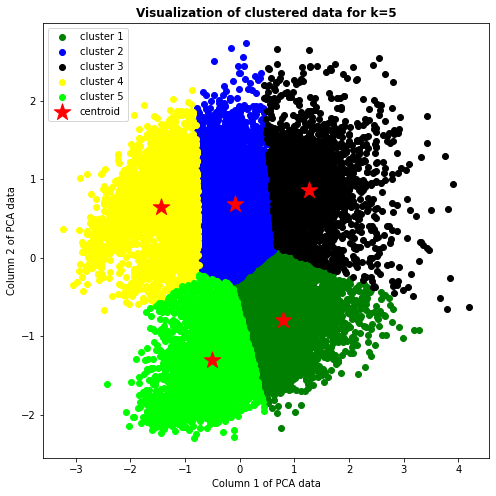

In [127]:
km = Kmeans(5,100)
km.findKMeans(X_std)
centroids = km.centroids
# print(centroids)
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(X_std[km.labels == 2, 0], X_std[km.labels == 2, 1],
            c='black', label='cluster 3')
plt.scatter(X_std[km.labels == 3, 0], X_std[km.labels == 3, 1],
            c='yellow', label='cluster 4')
plt.scatter(X_std[km.labels == 4, 0], X_std[km.labels == 4, 1],
            c='lime', label='cluster 5')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.xlabel('Column 1 of PCA data')
plt.ylabel('Column 2 of PCA data')
plt.title('Visualization of clustered data for k=5', fontweight='bold')

Clusters = 7

In [ ]:
km = Kmeans(7,100)
km.findKMeans(X_std)
centroids = km.centroids
print(centroids)
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels == 0, 0], X_std[km.labels == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels == 1, 0], X_std[km.labels == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(X_std[km.labels == 2, 0], X_std[km.labels == 2, 1],
            c='black', label='cluster 3')
plt.scatter(X_std[km.labels == 3, 0], X_std[km.labels == 3, 1],
            c='yellow', label='cluster 4')
plt.scatter(X_std[km.labels == 4, 0], X_std[km.labels == 4, 1],
            c='lime', label='cluster 5')
plt.scatter(X_std[km.labels == 5, 0], X_std[km.labels == 5, 1],
            c='purple', label='cluster 6')
plt.scatter(X_std[km.labels == 6, 0], X_std[km.labels == 6, 1],
            c='orange', label='cluster 7')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.xlabel('Column 1 of PCA data')
plt.ylabel('Column 2 of PCA data')
plt.title('Visualization of clustered data for k=7', fontweight='bold')

# Elbow method

In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(2,11)
for n in K:
  kmeanModel = KMeans(n_clusters=n)
  kmeanModel.fit(X_std)
  distortions.append(kmeanModel.inertia_)  

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters')
plt.show()

# Silhouette Score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
score = []
# print(X_std.shape)
R = range(2,11)
for n in R:
  kmeanModel = KMeans(n_clusters=n)
  kmeanModel.fit(X_std)
  label = kmeanModel.predict(X_std)
  # print(silhouette_score(X_std, label))
  score.append(silhouette_score(X_std, label))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(R, score, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score of different clusters')
plt.show()